# Tugas mentoring 7: customer segmentation
## Maria Denna

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
import plotly.offline as pyoff

import datetime

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

from scipy.cluster.hierarchy import dendrogram, linkage


import warnings
import os
warnings.filterwarnings("ignore")

py.offline.init_notebook_mode(connected = True)

In [3]:
df = pd.read_csv(r'transactions.csv')
df.head()

,customer_id,trans_date,trans_amount
0,CS5295,11-Feb-18,35
1,CS4768,15-Mar-20,39
2,CS2122,26-Feb-18,52
3,CS1217,16-Nov-16,99
4,CS1850,20-Nov-18,78


In [4]:
df.dtypes


customer_id     object
trans_date      object
trans_amount     int64
dtype: object

In [5]:
df.shape

(125000, 3)

In [6]:
df.isnull().mean().sort_values(ascending=False)

trans_amount    0.0
trans_date      0.0
customer_id     0.0
dtype: float64

In [8]:
df['trans_date'] = df['trans_date'].replace(['29-Feb-17'],'28-Feb-17')

In [9]:
df['trans_date'] = pd.to_datetime(df['trans_date'])

In [10]:
df['trans_date'] = pd.to_datetime(df['trans_date'], format="%d%m%Y")

In [11]:
df.dtypes

customer_id             object
trans_date      datetime64[ns]
trans_amount             int64
dtype: object

In [12]:
df_rfm = df.copy()

In [13]:
tday = pd.to_datetime("now")

In [17]:
df_rfm['days_from_last_purchase'] = (tday-df_rfm['trans_date']).astype('timedelta64[D]')
df_rfm.head()

,customer_id,trans_date,trans_amount,days_from_last_purchase,days_from_lasst_purchase
0,CS5295,2018-02-11,35,1294.0,1294.0
1,CS4768,2020-03-15,39,531.0,531.0
2,CS2122,2018-02-26,52,1279.0,1279.0
3,CS1217,2016-11-16,99,1746.0,1746.0
4,CS1850,2018-11-20,78,1012.0,1012.0


In [18]:
lastpurchaseday = df_rfm[['customer_id','days_from_last_purchase']].groupby('customer_id').min().reset_index()

In [19]:
lastpurchaseday.rename(columns={'days_from_last_purchase':'recency'}, inplace=True)

In [20]:
lastpurchaseday.head()

,customer_id,recency
0,CS1112,592.0
1,CS1113,566.0
2,CS1114,563.0
3,CS1115,541.0
4,CS1116,734.0


In [21]:
plot_data = [go.Histogram(x=lastpurchaseday['recency'])]
plot_layout = go.Layout(title='Recency')
fig = go.Figure(data=plot_data, layout=plot_layout)

pyoff.iplot(fig)

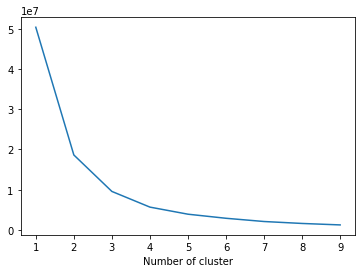

In [52]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = lastpurchaseday[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_   
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [53]:
# number of clusters: 4

In [54]:
kmeans = KMeans(n_clusters=4)
lastpurchaseday['recency_cluster'] = kmeans.fit_predict(lastpurchaseday[['recency']])

In [55]:
lastpurchaseday

,customer_id,recency,recency_cluster
0,CS1112,592.0,1
1,CS1123,640.0,1
2,CS1124,604.0,1
3,CS1128,606.0,1
4,CS1129,637.0,1
...,...,...,...
6884,CS8888,855.0,2
6885,CS8941,843.0,2
6886,CS8942,883.0,2
6887,CS8951,867.0,2


In [56]:
lastpurchaseday.groupby('recency_cluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,911.0,733.846323,41.147984,681.0,698.0,725.0,763.0,835.0
1,2101.0,627.404093,24.722536,592.0,605.0,624.0,647.0,680.0
2,179.0,939.458101,98.153698,838.0,874.5,919.0,969.5,1388.0
3,3698.0,556.168740,17.447744,530.0,541.0,555.0,570.0,591.0


In [57]:
# orderding cluster
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

lastpurchaseday = order_cluster('recency_cluster', 'recency',lastpurchaseday,False)

In [58]:
lastpurchaseday

,customer_id,recency,recency_cluster
0,CS1112,592.0,2
1,CS1123,640.0,2
2,CS1124,604.0,2
3,CS1128,606.0,2
4,CS1129,637.0,2
...,...,...,...
6884,CS8888,855.0,0
6885,CS8941,843.0,0
6886,CS8942,883.0,0
6887,CS8951,867.0,0


In [59]:
lastpurchaseday.groupby('recency_cluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,179.0,939.458101,98.153698,838.0,874.5,919.0,969.5,1388.0
1,911.0,733.846323,41.147984,681.0,698.0,725.0,763.0,835.0
2,2101.0,627.404093,24.722536,592.0,605.0,624.0,647.0,680.0
3,3698.0,556.168740,17.447744,530.0,541.0,555.0,570.0,591.0


In [60]:
fq = df_rfm[['customer_id','trans_date']].groupby(['customer_id']).count().reset_index()
fq.rename(columns={'trans_date':'frequency'}, inplace=True)

In [61]:
fq

,customer_id,frequency
0,CS1112,15
1,CS1113,20
2,CS1114,19
3,CS1115,22
4,CS1116,13
...,...,...
6884,CS8996,13
6885,CS8997,14
6886,CS8998,13
6887,CS8999,12


In [62]:
plot_data = [go.Histogram(x=fq['frequency'])]
plot_layout = go.Layout(title='Frequency')
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [63]:
# frequency clusters

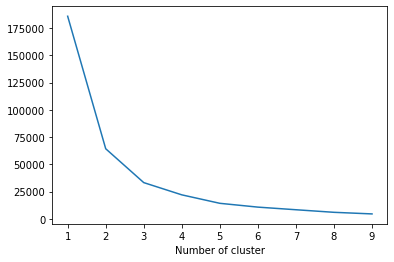

In [64]:
from sklearn.cluster import KMeans

sse={} # error
transaction_recency = fq[['frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(transaction_recency)
    transaction_recency["clusters"] = kmeans.labels_  
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [65]:
# number of clusters: 4

In [66]:
kmeans=KMeans(n_clusters=4)
fq['frequency_cluster']=kmeans.fit_predict(fq[['frequency']])

In [67]:
fq = order_cluster('frequency_cluster', 'frequency', fq, True )
fq

,customer_id,frequency,frequency_cluster
0,CS1112,15,1
1,CS1114,19,1
2,CS1117,17,1
3,CS1118,15,1
4,CS1119,15,1
...,...,...,...
6884,CS6105,25,3
6885,CS7394,25,3
6886,CS7580,26,3
6887,CS8316,25,3


In [68]:
fq.groupby('frequency_cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,1743.0,11.565118,2.182326,4.0,10.0,12.0,13.0,14.0
1,2390.0,17.075732,1.384796,15.0,16.0,17.0,18.0,19.0
2,1975.0,21.717975,1.384879,20.0,20.0,22.0,23.0,24.0
3,781.0,27.065301,2.128461,25.0,25.0,27.0,28.0,39.0


In [69]:
# revenue
rev = df_rfm[['customer_id','trans_amount']].groupby('customer_id').sum().reset_index()
rev.rename(columns = {'trans_amount':'revenue'}, inplace = True)

In [70]:
rev.head()

,customer_id,revenue
0,CS1112,1012
1,CS1113,1490
2,CS1114,1432
3,CS1115,1659
4,CS1116,857


In [71]:
plot_data = [go.Histogram(x=rev['revenue'])]
plot_layout = go.Layout(title='Revenue')
fig = go.Figure(data=plot_data, layout=plot_layout)

pyoff.iplot(fig)

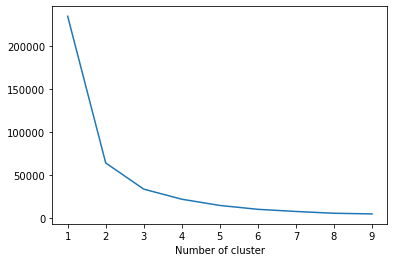

In [72]:
# revenue clusters

from sklearn.cluster import KMeans

sse={} # error
transaction_rev = rev[['revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(transaction_recency)
    transaction_recency["clusters"] = kmeans.labels_  
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [73]:
# cluster numbers: 4

In [74]:
kmeans = KMeans(n_clusters=4)
rev['revenue_cluster'] = kmeans.fit_predict(rev[['revenue']])

In [75]:
rev = order_cluster('revenue_cluster', 'revenue',rev,True)

In [76]:
rev

,customer_id,revenue,revenue_cluster
0,CS1112,1012,1
1,CS1116,857,1
2,CS1117,1185,1
3,CS1118,1011,1
4,CS1119,1158,1
...,...,...,...
6884,CS8996,582,0
6885,CS8997,543,0
6886,CS8998,624,0
6887,CS8999,383,0


In [77]:
rev.groupby('revenue_cluster')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
revenue_cluster,,,,,,,,
0,1814.0,561.571665,143.949189,149.0,461.0,568.0,675.00,809.0
1,1713.0,1059.451839,123.044243,810.0,966.0,1075.0,1165.00,1244.0
2,2200.0,1430.950455,110.037580,1245.0,1336.0,1429.0,1522.25,1637.0
3,1162.0,1843.688468,174.947924,1638.0,1707.0,1799.0,1943.75,2933.0


In [78]:
# RFM score

In [82]:
rfmtable = pd.merge(lastpurchaseday, fq, on='customer_id')

In [83]:
rfmtable.head()

,customer_id,recency,recency_cluster,frequency,frequency_cluster
0,CS1112,592.0,2,15,1
1,CS1123,640.0,2,19,1
2,CS1124,604.0,2,18,1
3,CS1128,606.0,2,26,3
4,CS1129,637.0,2,12,0


In [84]:
rfmtable=pd.merge(rfmtable, rev, on='customer_id')

In [85]:
rfmtable

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,revenue_cluster
0,CS1112,592.0,2,15,1,1012,1
1,CS1123,640.0,2,19,1,1331,2
2,CS1124,604.0,2,18,1,1127,1
3,CS1128,606.0,2,26,3,1921,3
4,CS1129,637.0,2,12,0,853,1
...,...,...,...,...,...,...,...
6884,CS8888,855.0,0,14,0,640,0
6885,CS8941,843.0,0,9,0,520,0
6886,CS8942,883.0,0,13,0,472,0
6887,CS8951,867.0,0,22,2,940,1


In [86]:
rfmtable['rfm'] = rfmtable['recency_cluster'] + rfmtable['frequency_cluster'] + rfmtable['revenue_cluster']
rfmtable.groupby('rfm')['recency','frequency','revenue'].mean()

,recency,frequency,revenue
rfm,,,
0,956.773913,9.800000,461.034783
1,756.154762,11.172619,545.023810
2,661.947935,12.236984,609.917415
3,612.204499,13.221881,709.776074
4,611.241455,16.216097,1000.650496
5,596.517176,17.824427,1188.397901
6,595.140370,20.097933,1395.164309
7,569.042157,21.833333,1520.202941
8,581.815261,24.899598,1791.365462


In [87]:
rfmtable['segment'] = 'Low-Value'
rfmtable.loc[rfmtable['rfm']>3,'segment'] = 'Mid-Value' 
rfmtable.loc[rfmtable['rfm']>6,'segment'] = 'High-Value'

In [88]:
rfmtable

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,revenue_cluster,rfm,segment
0,CS1112,592.0,2,15,1,1012,1,4,Mid-Value
1,CS1123,640.0,2,19,1,1331,2,5,Mid-Value
2,CS1124,604.0,2,18,1,1127,1,4,Mid-Value
3,CS1128,606.0,2,26,3,1921,3,8,High-Value
4,CS1129,637.0,2,12,0,853,1,3,Low-Value
...,...,...,...,...,...,...,...,...,...
6884,CS8888,855.0,0,14,0,640,0,0,Low-Value
6885,CS8941,843.0,0,9,0,520,0,0,Low-Value
6886,CS8942,883.0,0,13,0,472,0,0,Low-Value
6887,CS8951,867.0,0,22,2,940,1,3,Low-Value


In [89]:
rfmtable.groupby('segment').count()['rfm']

segment
High-Value    2029
Low-Value     1986
Mid-Value     2874
Name: rfm, dtype: int64

In [90]:
# segment visualization

In [92]:
#Revenue vs Frequency
tx_graph = rfmtable.query("revenue < 2000 and frequency < 100")

plot_data = [
    go.Scatter(
        x=tx_graph.query("segment == 'Low-Value'")['frequency'],
        y=tx_graph.query("segment == 'Low-Value'")['revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'purple',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("segment == 'Mid-Value'")['frequency'],
        y=tx_graph.query("segment == 'Mid-Value'")['revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'red',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("segment == 'High-Value'")['frequency'],
        y=tx_graph.query("segment == 'High-Value'")['revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'green',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [93]:
#Revenue vs Recency

tx_graph = rfmtable.query("revenue < 2000 and recency < 1000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("segment == 'Low-Value'")['recency'],
        y=tx_graph.query("segment == 'Low-Value'")['revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'brown',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("segment == 'Mid-Value'")['recency'],
        y=tx_graph.query("segment == 'Mid-Value'")['revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'purple',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("segment == 'High-Value'")['recency'],
        y=tx_graph.query("segment == 'High-Value'")['revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'green',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [95]:
# Recency vs Frequency
tx_graph = rfmtable.query("recency < 1000 and frequency < 100")

plot_data = [
    go.Scatter(
        x=tx_graph.query("segment == 'Low-Value'")['recency'],
        y=tx_graph.query("segment == 'Low-Value'")['frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("segment == 'Mid-Value'")['recency'],
        y=tx_graph.query("segment == 'Mid-Value'")['frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("segment == 'High-Value'")['recency'],
        y=tx_graph.query("segment == 'High-Value'")['frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [96]:
fig = px.scatter_3d(rfmtable, x='recency', y='frequency', z='revenue', color='segment',opacity = 0.8, height=800)
fig.show()

The customers are divided into 3 segments. 

Strategies recommendation for each segment:
* High Value: Improve Retention
* Mid Value: Improve Retention + Increase Frequency
* Low Value: Increase Frequency